In [1]:
import pandas as pd
import pyarrow

from collections import defaultdict
from datetime import datetime

from sklearn.preprocessing import RobustScaler, QuantileTransformer
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pylab

import os
import io
import re
from glob import iglob

%matplotlib inline
pylab.rcParams['image.cmap'] = 'viridis'
pylab.rcParams['figure.figsize'] = (35.0, 12.0)
# pylab.rcParams['figure.figsize'] = (100, 100)
pylab.rcParams['figure.dpi'] = 100
pylab.rcParams['font.size'] = 25

In [2]:
sample_iperf_out = io.StringIO("""
[  5] local ::1 port 35478 connected to ::1 port 7001
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-1.01   sec  97.5 MBytes   811 Mbits/sec    0   4.06 MBytes
[  5]   1.01-2.01   sec  77.5 MBytes   649 Mbits/sec    0   4.06 MBytes
[  5]   2.01-3.00   sec  98.8 MBytes   837 Mbits/sec    0   4.06 MBytes
[  5]   3.00-4.00   sec   138 MBytes  1.15 Gbits/sec    0   4.06 MBytes
[  5]   4.00-5.00   sec   185 MBytes  1.56 Gbits/sec    0   4.06 MBytes
[  5]   5.00-6.00   sec   191 MBytes  1.60 Gbits/sec    0   4.06 MBytes
[  5]   6.00-7.00   sec   144 MBytes  1.21 Gbits/sec    0   4.06 MBytes
[  5]   7.00-8.00   sec  43.8 MBytes   367 Mbits/sec    0   4.06 MBytes
[  5]   8.00-9.00   sec  66.2 MBytes   556 Mbits/sec    0   4.06 MBytes
[  5]   9.00-10.00  sec  82.5 MBytes   692 Mbits/sec    0   4.06 MBytes
[ ID] Interval           Transfer     Bitrate         Retr
[  5]   0.00-10.00  sec  1.10 GBytes   943 Mbits/sec    0             sender
[  5]   0.00-10.03  sec  1.09 GBytes   932 Mbits/sec                  receiver
""")

Existing CSV/JSON parsers broken for iperf3

https://github.com/esnet/iperf/blob/master/contrib/iperf3_to_gnuplot.py

https://gist.github.com/mtarsel/04bb3f18d1a5336b764e

DIY iperf3 parser

In [3]:
iperf3_tbl = defaultdict(list)

for file in iglob('data/*.log'):
    filename_dateparse = pd.datetime.strptime(file[-20:], '%Y-%m-%dT%H:%M.log')
    iperf3_tbl['datetime'].append(filename_dateparse)
    
    # which machine does the log come from?
    if 'novastor' in file:
        iperf3_tbl["machines"].append("novastor-spartan")
    else:
        iperf3_tbl["machines"].append("raijin-spartan")
            
    with open(file, 'r') as f:
        # is the file empty or the test failed?
        if (os.path.getsize(file) < 55):
            iperf3_tbl["bitrate_receiver"].append(float(0))
            iperf3_tbl["bitrate_sender"].append(float(0))
        else:
            for line in f:
                header = re.search('\[\sID\]\s(\w+)\s+(\w+)\s+(\w+)\s+(\w+)', line)
                info = re.search('\[\s+5\]\s+([0-9]*\.?[0-9]+-[0-9]*\.?[0-9]+)\s+sec\s+([0-9]*\.?[0-9]+)\s([M|G|K]Bytes)\s+([0-9]*\.?[0-9]+)\s+(\w+/sec)\s+\d+\s+[0-9]*\.?[0-9]+\s+([M|G|K]Bytes)', line)
                receiver = re.search('\[\s+5\]\s+([0-9]*\.?[0-9]+-[0-9]*\.?[0-9]+)\s+sec\s+([0-9]*\.?[0-9]+)\s([M|G|K]Bytes)\s+([0-9]*\.?[0-9]+)\s+(\w+/sec)\s+receiver', line)
                sender =   re.search('\[\s+5\]\s+([0-9]*\.?[0-9]+-[0-9]*\.?[0-9]+)\s+sec\s+([0-9]*\.?[0-9]+)\s([M|G|K]Bytes)\s+([0-9]*\.?[0-9]+)\s+(\w+/sec)\s+\d+\s+sender', line)
                if header:
                    pass
                if info:
                    pass
                if receiver:
                    if receiver.group(3) == 'GBytes':
                        iperf3_tbl["bitrate_receiver"].append(float(receiver.group(4)))
                    else:
                        iperf3_tbl["bitrate_receiver"].append(float(receiver.group(4))/1024)
                if sender:
                    if sender.group(3) == 'GBytes':
                        iperf3_tbl["bitrate_sender"].append(float(sender.group(4)))
                    else:
                        iperf3_tbl["bitrate_sender"].append(float(sender.group(4))/1024)
                        


In [4]:
#assert(len(iperf3_tbl['bitrate_sender']) == len(iperf3_tbl['datetime']))
#assert(len(iperf3_tbl['bitrate_receiver']) == len(iperf3_tbl['bitrate_sender']))
#len(iperf3_tbl['bitrate_sender']), len(iperf3_tbl['bitrate_receiver'])
len(iperf3_tbl['datetime']), len(iperf3_tbl['bitrate_sender']), len(iperf3_tbl['bitrate_receiver']), len(iperf3_tbl['machines'])

(499, 499, 499, 499)

In [5]:
iperf3_df = pd.DataFrame(iperf3_tbl)
iperf3_df = iperf3_df.set_index(pd.DatetimeIndex(iperf3_df['datetime']))
del iperf3_df['datetime']

Save it in Arrow

In [6]:
# XXX: https://twitter.com/braincode/status/921383742891061248
#table = pa.Table.from_pandas(iperf3_df)
#table_serialized = pyarrow.serialize(table).to_buffer()
#with open('iperf3.data') as f:
#    f.write(table_serialized)

Deserialize if you want to use it (uncomment)

In [7]:
#with open('iperf3_data') as f:
#    table_deserialized = pyarrow.deserialize(f.read())
#    iperf3_df = table_deserialized.to_pandas()

In [8]:
raijin_spartan = iperf3_df[iperf3_df.machines == 'raijin-spartan']
novastor_spartan = iperf3_df[iperf3_df.machines == 'novastor-spartan']
del iperf3_df['machines']

In [9]:
# Normalize this a bit..
#scaler = QuantileTransformer() 
#del novastor_spartan['machines']
#scaled_values = scaler.fit_transform(novastor_spartan) 
#novastor_spartan.loc[:,:] = scaled_values

#novastor_spartan.bitrate_receiver.plot(figsize=(30,10))
novastor_spartan.describe()

,bitrate_receiver,bitrate_sender
count,96.000000,96.000000
mean,453.173971,459.012482
std,455.156863,461.015616
min,0.202148,0.211914
25%,0.630615,0.641357
50%,435.912109,441.418457
75%,908.250000,920.250000
max,930.000000,941.000000


In [10]:
iperf3_df.describe()

,bitrate_receiver,bitrate_sender
count,499.000000,499.000000
mean,97.075891,100.041130
std,280.707079,286.293157
min,0.000000,0.000000
25%,0.240234,0.249512
50%,0.378906,0.386719
75%,0.767578,0.778320
max,976.000000,987.000000


In [11]:
# Normalize this a bit..
scaler = QuantileTransformer() 
scaled_values = scaler.fit_transform(iperf3_df) 
iperf3_df.loc[:,:] = scaled_values

In [12]:
iperf3_df.describe()

,bitrate_receiver,bitrate_sender
count,4.990000e+02,4.990000e+02
mean,4.834818e-01,4.834924e-01
std,3.131531e-01,3.131608e-01
min,1.000000e-07,1.000000e-07
25%,2.492492e-01,2.497497e-01
50%,5.000000e-01,4.998332e-01
75%,7.502503e-01,7.506241e-01
max,9.999999e-01,9.999999e-01


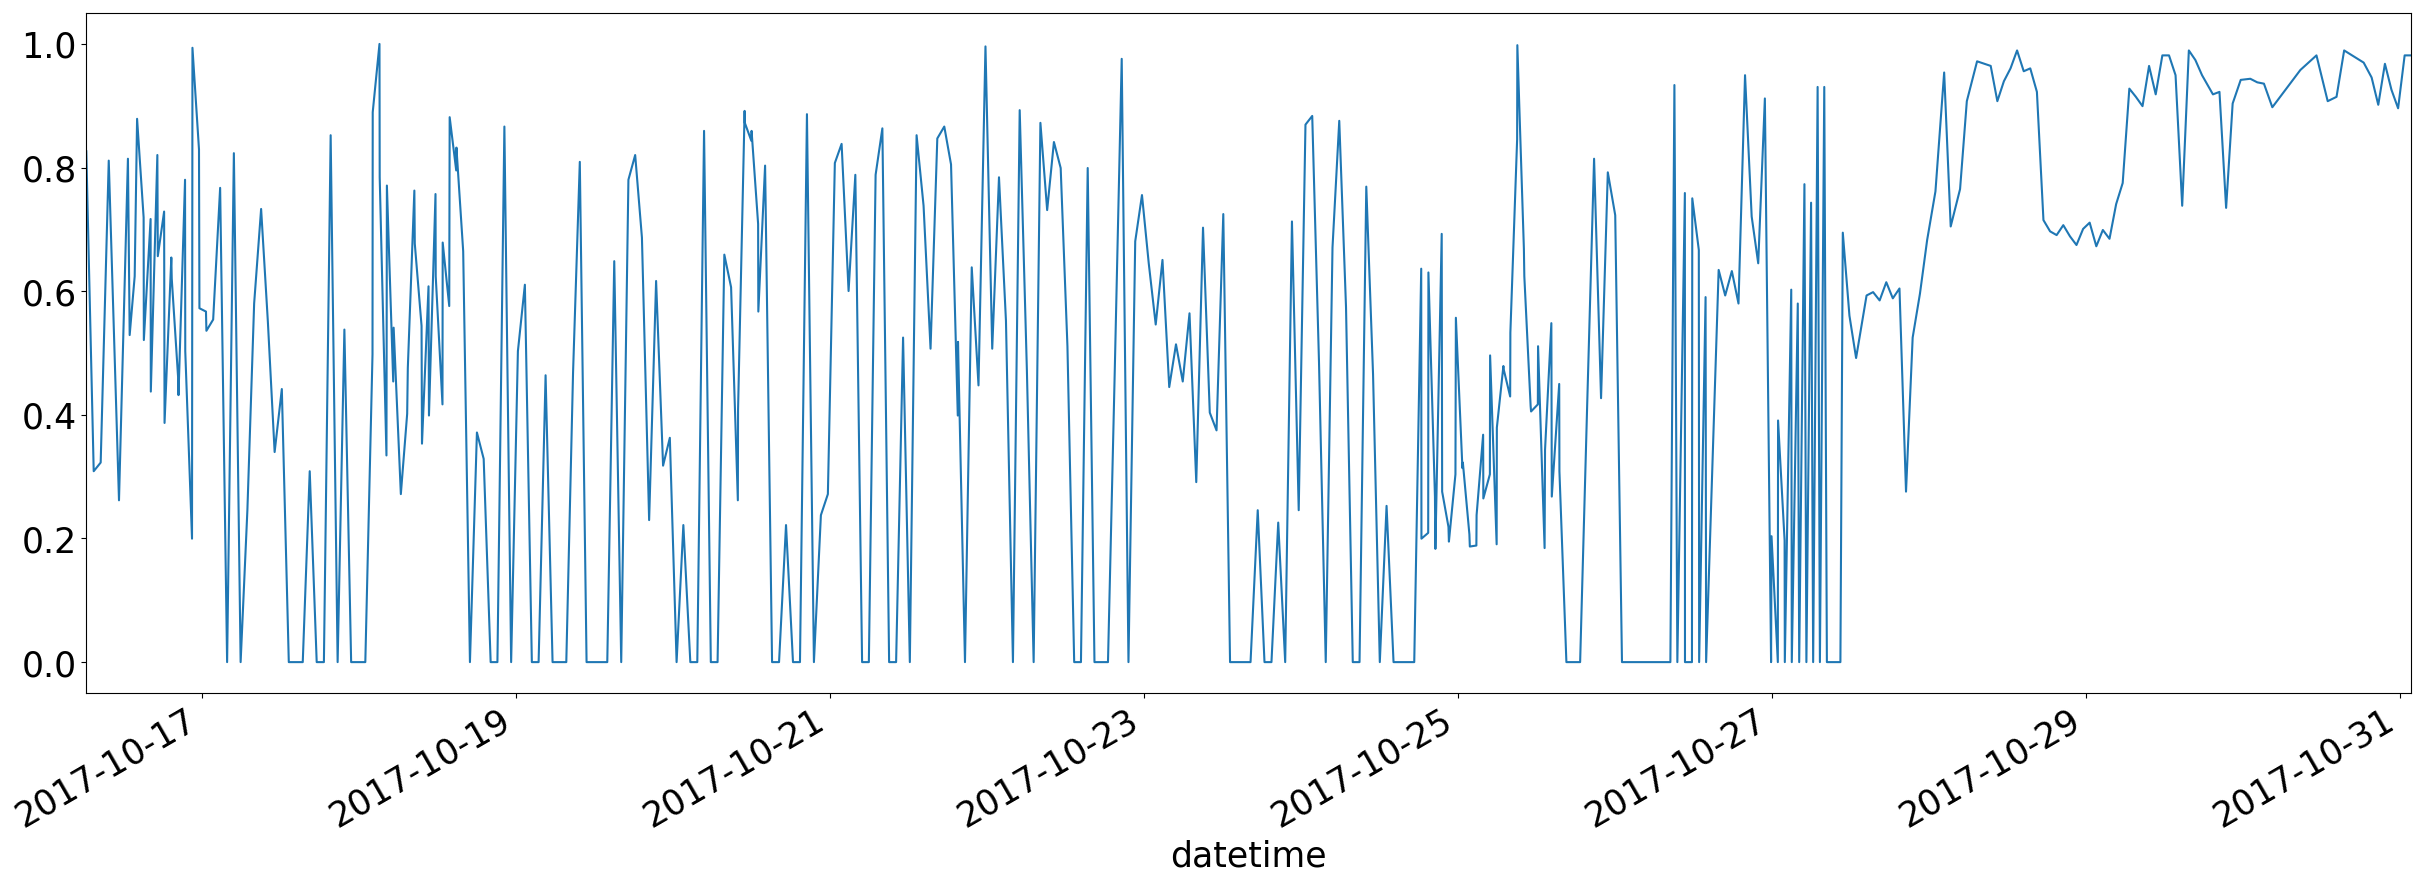

In [13]:
iperf3_df['20171016':].bitrate_receiver.plot(figsize=(30,10))

/Users/romanvg/.miniconda/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/romanvg/.miniconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


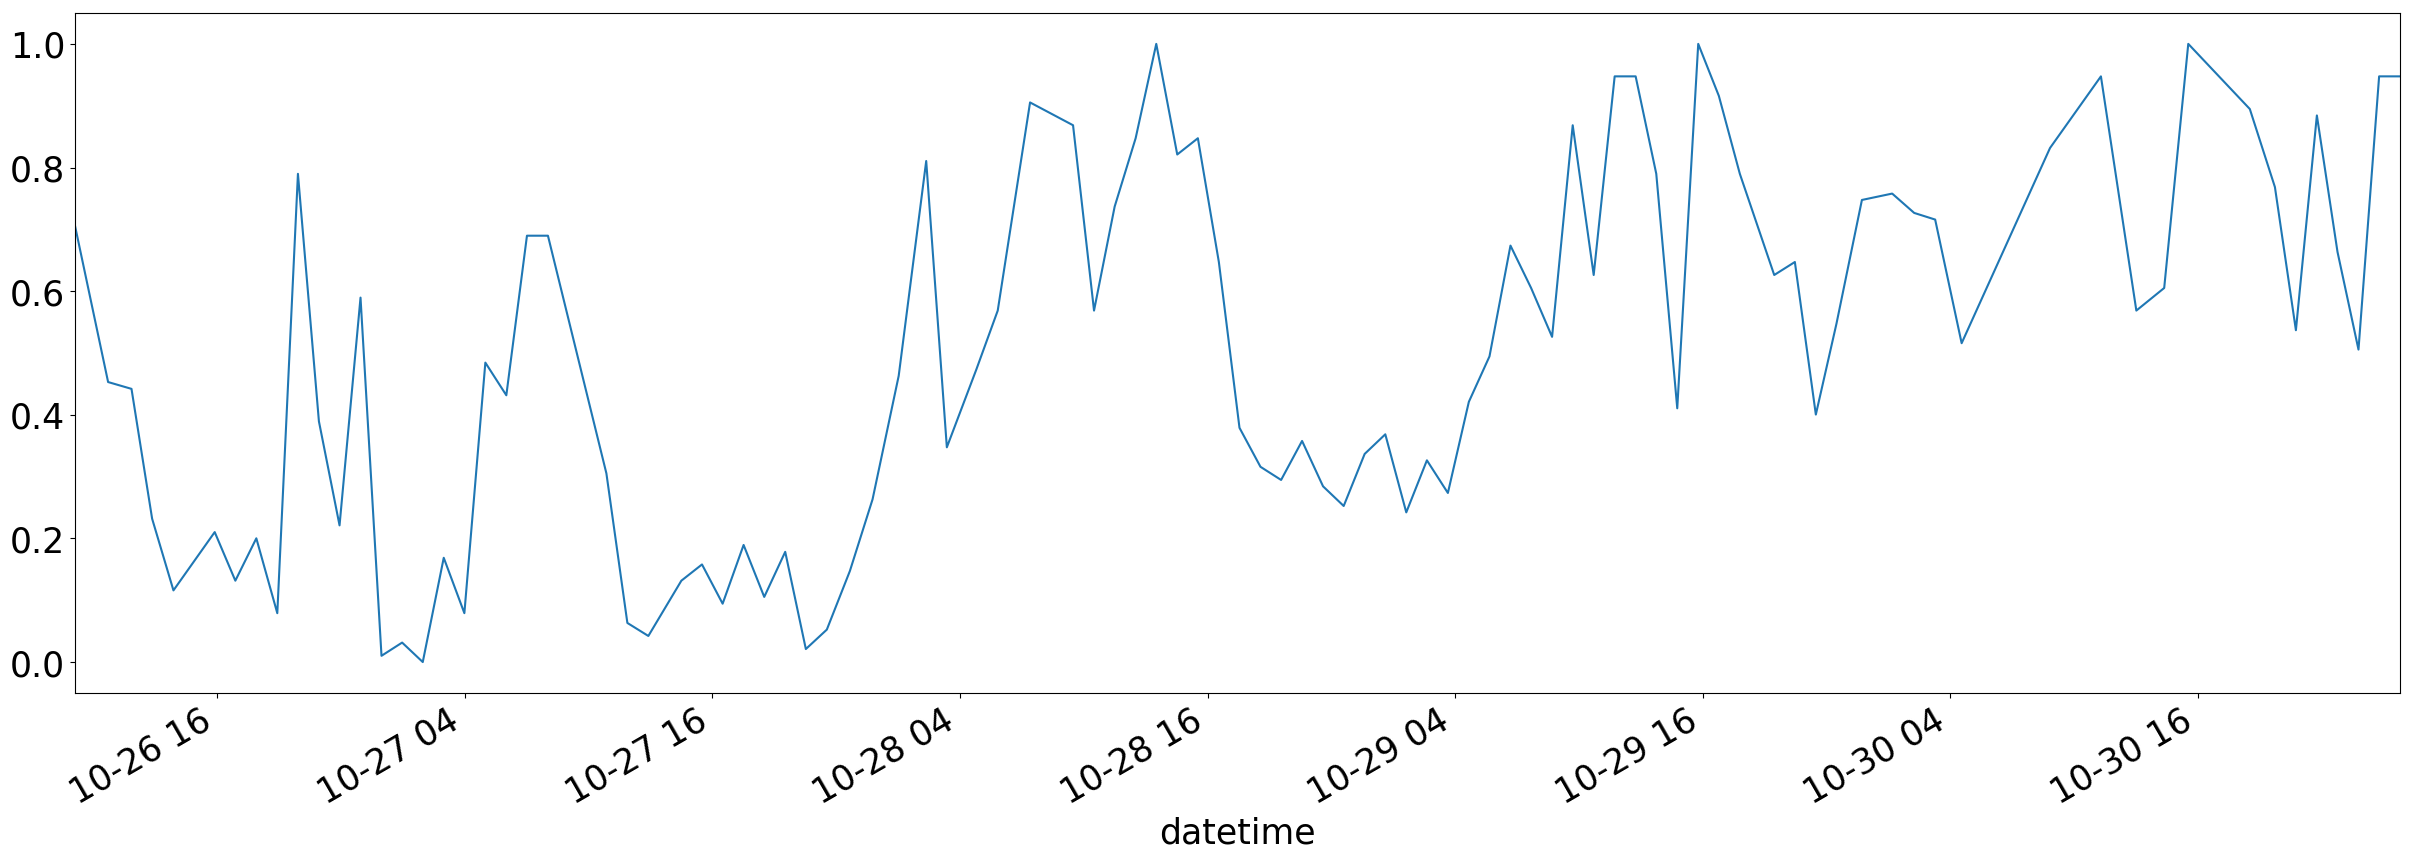

In [14]:
# Normalize this a bit..
scaler = QuantileTransformer() 
del novastor_spartan['machines']
scaled_novastor = scaler.fit_transform(novastor_spartan)
novastor_spartan.loc[:,:] = scaled_novastor

novastor_spartan['20171016':].bitrate_receiver.plot(figsize=(30,10))

/Users/romanvg/.miniconda/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/romanvg/.miniconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


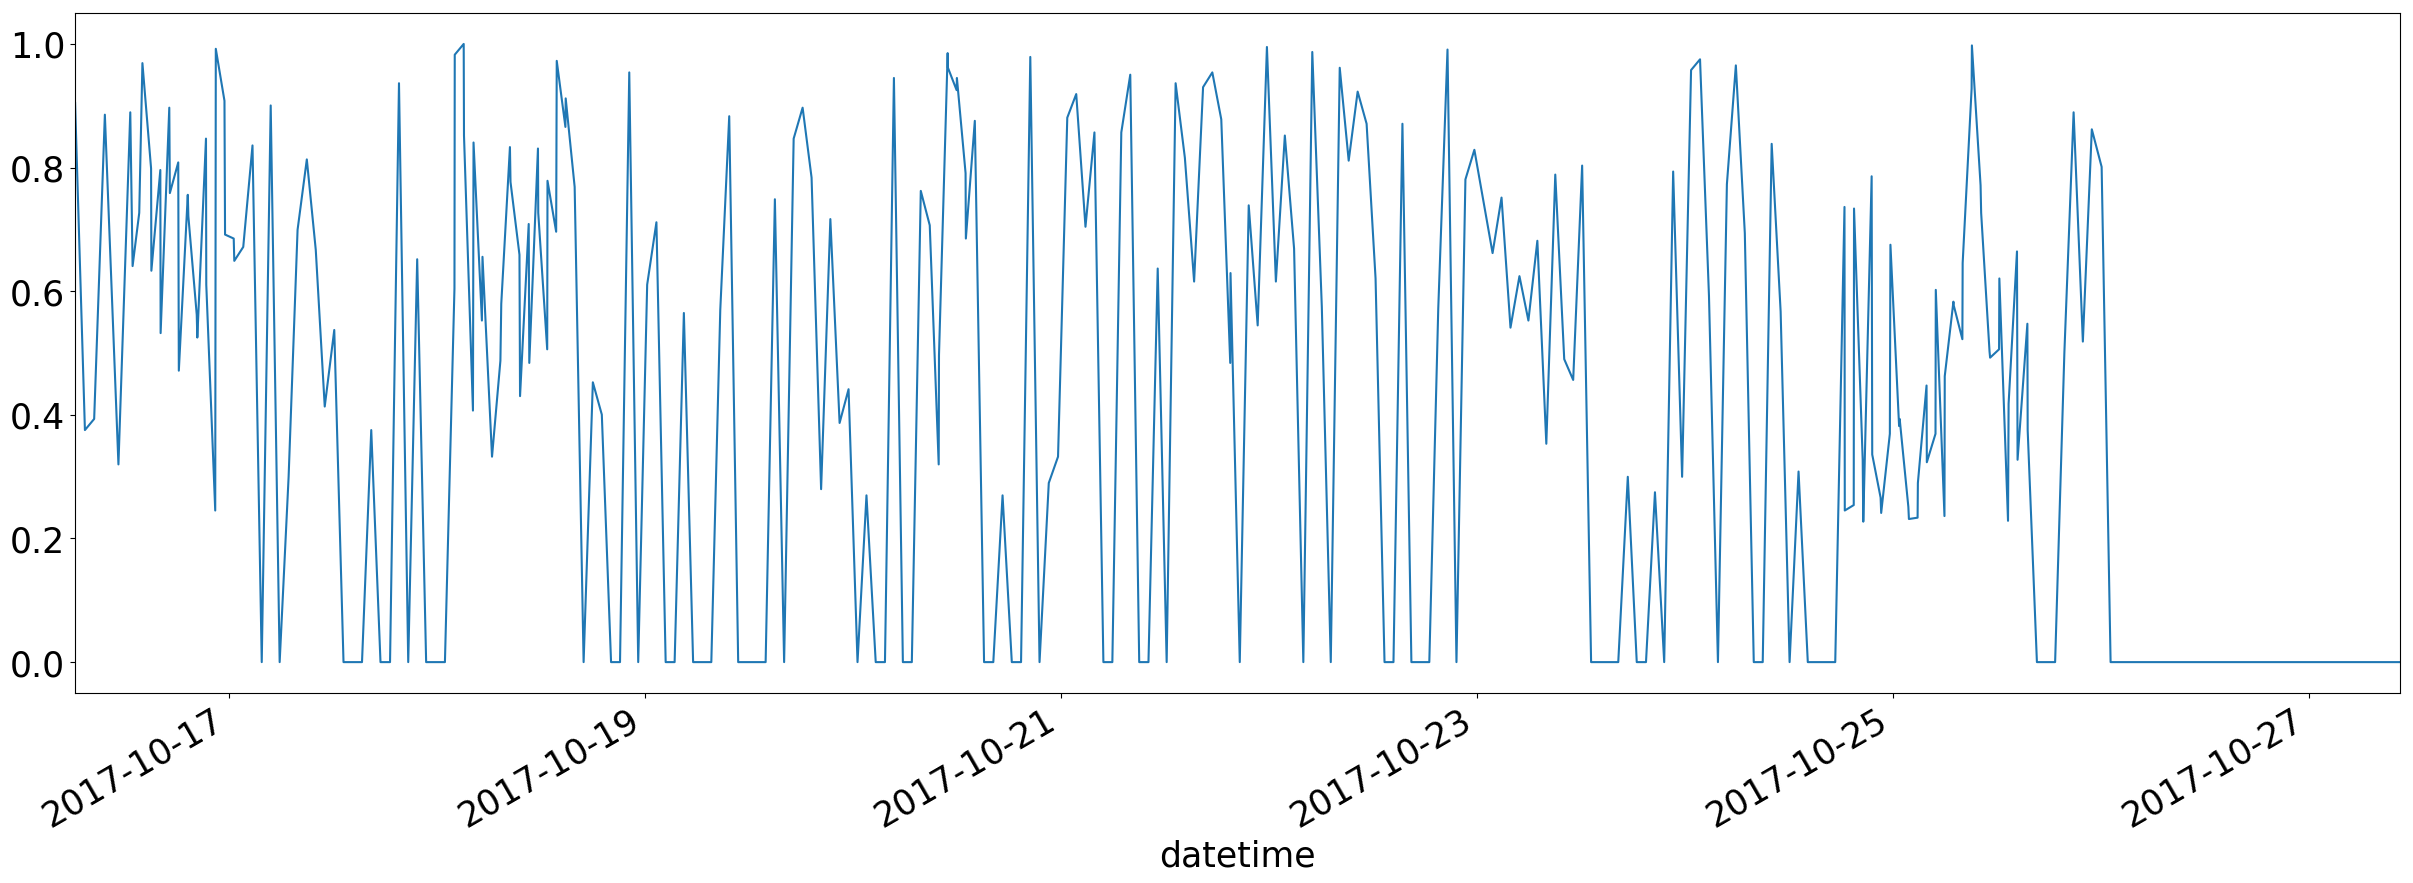

In [15]:
scaler = QuantileTransformer() 
del raijin_spartan['machines']
scaled_raijin = scaler.fit_transform(raijin_spartan)
raijin_spartan.loc[:,:] = scaled_raijin

raijin_spartan['20171016':].bitrate_receiver.plot(figsize=(30,10))